In [2]:
import gym
import numpy as np
import random
import math # to use epsilon decay
# Potentially: from IPython.display import clear_output # To clear output during training loops
# Potentially: import matplotlib.pyplot as plt # For plotting rewards

In [3]:
env = gym.make("Taxi-v3")

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [6]:
#intialize Q table , empty numpy array with states and actions
num_states=env.observation_space.n
num_actions=env.action_space.n
q_table=np.zeros((num_states,num_actions))
print("Actions: 0=South, 1=North, 2=East, 3=West, 4=Pickup, 5=Dropoff")


Actions: 0=South, 1=North, 2=East, 3=West, 4=Pickup, 5=Dropoff


In [8]:
#hyperparameters
learning_rate = 0.1  # Alpha
discount_factor = 0.99 # Gamma

epsilon = 1.0  # Initial exploration rate
max_epsilon = 1.0
min_epsilon = 0.01
epsilon_decay_rate = 0.005 #have to

num_episodes = 25000



In [26]:
rewards_all_episodes = []  # Store rewards for plotting learning curve

for episode in range(num_episodes):
    # Reset environment for new episode
    state = env.reset()  # Get initial state
    done = False
    current_episode_reward = 0

    while not done:
        # STEP 1: EXPLORATION vs EXPLOITATION (Epsilon-greedy strategy)
        # Generate random number between 0 and 1
        exploration_threshold = random.uniform(0, 1)

        if exploration_threshold > epsilon:
            # EXPLOITATION: choose action with highest q-value for current state
            action = np.argmax(q_table[state, :])
        else:
            # EXPLORATION: choose random action
            action = env.action_space.sample()

        # STEP 2: take action and observe results
        #print(env.step(action))
        next_state, reward, done, info = env.step(action)

        # STEP 3: UPDATE Q-TABLE using Bellman equation
        # Q(s,a) = Q(s,a) + α[r + γ * max(Q(s',a')) - Q(s,a)]

        if done:
            # If episode is finished, there's no future reward
            # Q(s,a) = Q(s,a) + α[r + 0 - Q(s,a)]
            q_table[state, action] = q_table[state, action] + learning_rate * (
                reward - q_table[state, action]
            )
        else:
            # Normal Q-value update with future reward consideration
            # Q(s,a) = Q(s,a) + α[r + γ * max(Q(s',a')) - Q(s,a)]
            q_table[state, action] = q_table[state, action] + learning_rate * (
                reward + discount_factor * np.max(q_table[next_state, :]) - q_table[state, action]
            )

        # STEP 4: UPDATE STATE and accumulate reward
        state = next_state
        current_episode_reward += reward

    # STEP 5: DECAY EPSILON after each episode
    # Gradually reduce exploration as agent learns
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * math.exp(-epsilon_decay_rate * episode)

    # Store episode reward for analysis
    rewards_all_episodes.append(current_episode_reward)

    # Print progress every 1000 episodes
    if (episode + 1) % 1000 == 0:
        #clear_output(wait=True)
        avg_reward = np.mean(rewards_all_episodes[-1000:])  # Average of last 1000 episodes
        print(f"Episode: {episode + 1}/{num_episodes}")
        print(f"Epsilon: {epsilon:.3f}")
        print(f"Average reward (last 1000 episodes): {avg_reward:.2f}")
        print(f"Current episode reward: {current_episode_reward}")
        print("-" * 50)

print("Training finished!")

Episode: 1000/25000
Epsilon: 0.017
Average reward (last 1000 episodes): -41.40
Current episode reward: 7
--------------------------------------------------
Episode: 2000/25000
Epsilon: 0.010
Average reward (last 1000 episodes): 5.85
Current episode reward: 9
--------------------------------------------------
Episode: 3000/25000
Epsilon: 0.010
Average reward (last 1000 episodes): 6.18
Current episode reward: 9
--------------------------------------------------
Episode: 4000/25000
Epsilon: 0.010
Average reward (last 1000 episodes): 6.01
Current episode reward: 12
--------------------------------------------------
Episode: 5000/25000
Epsilon: 0.010
Average reward (last 1000 episodes): 6.25
Current episode reward: 10
--------------------------------------------------
Episode: 6000/25000
Epsilon: 0.010
Average reward (last 1000 episodes): 6.11
Current episode reward: 5
--------------------------------------------------
Episode: 7000/25000
Epsilon: 0.010
Average reward (last 1000 episodes): 

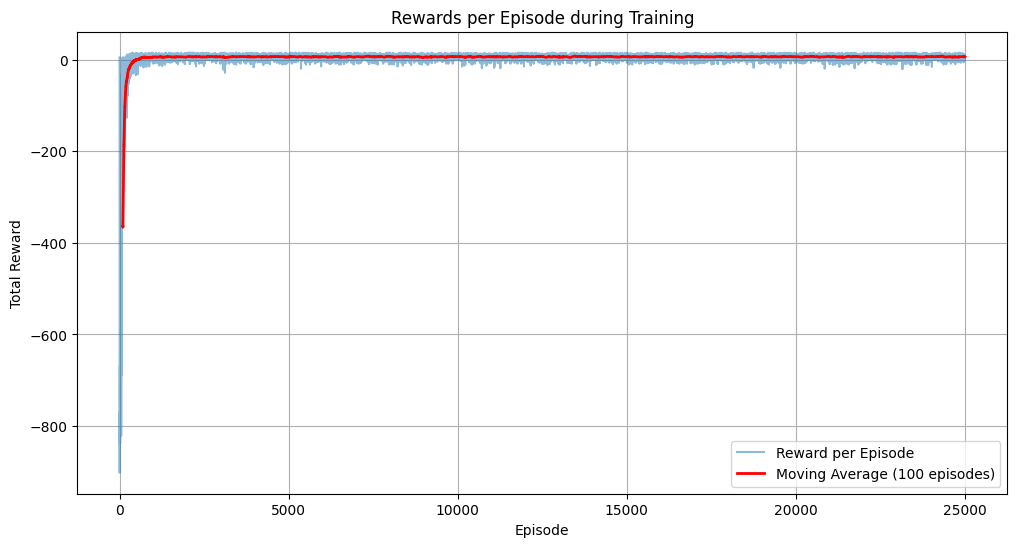

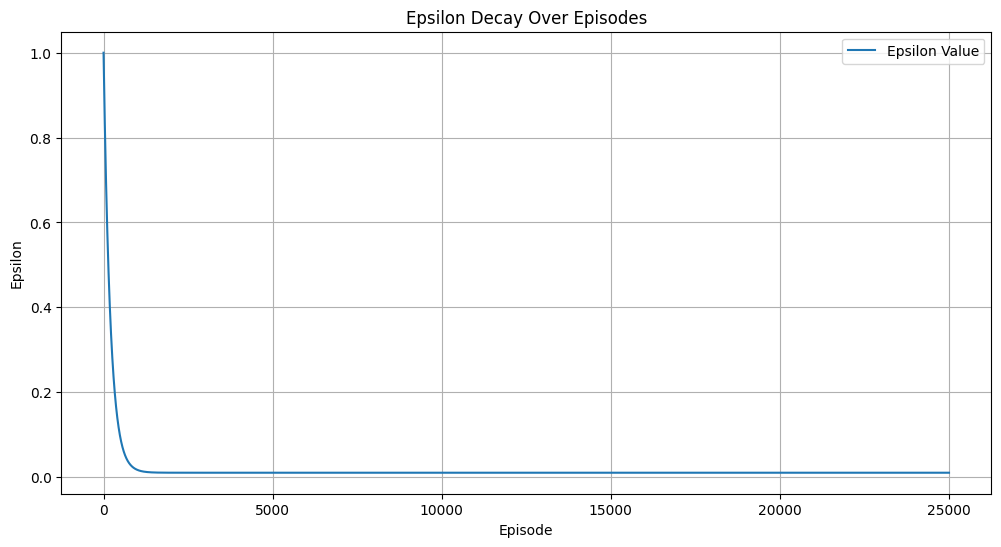

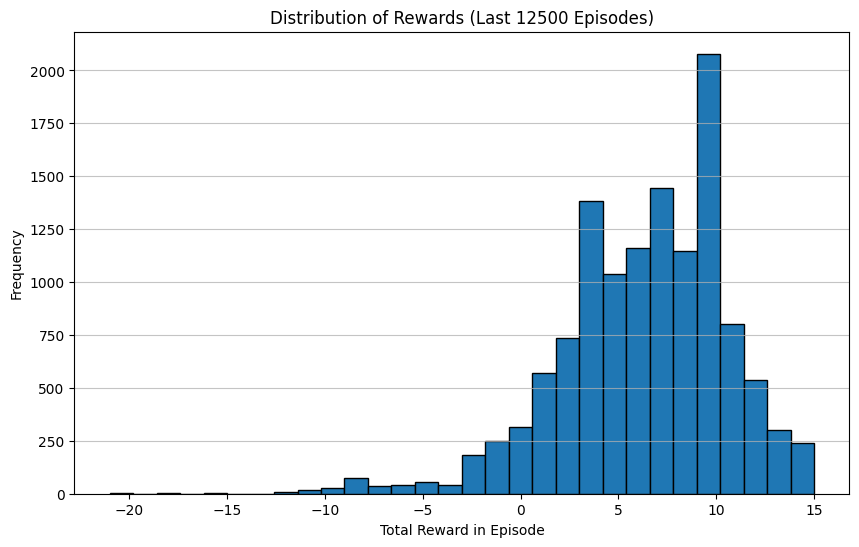

Number of episodes plotted: 25000
Final moving average reward (last 100 episodes of the moving average): 5.93

Summary Statistics for All Episodes:
Average reward: 4.27
Standard deviation of reward: 29.98
Max reward: 15.00
Min reward: -902.00

Summary Statistics for Last 10% of Episodes (2500 episodes):
Average reward: 6.16
Standard deviation of reward: 4.34
Max reward: 15.00
Min reward: -21.00


In [27]:
import matplotlib.pyplot as plt

# Calculate a moving average of rewards to smooth out the curve
# This makes it easier to see trends.
window_size = 100 # Plot average reward over this many episodes
if len(rewards_all_episodes) >= window_size:
    moving_avg_rewards = np.convolve(rewards_all_episodes, np.ones(window_size)/window_size, mode='valid')
else:
    # Handle cases where there are fewer episodes than the window size
    # For simplicity, we can just plot the raw rewards or a smaller window
    moving_avg_rewards = rewards_all_episodes
    print(f"Warning: Fewer episodes ({len(rewards_all_episodes)}) than moving average window ({window_size}). Plotting raw or partially averaged rewards.")


# 1. Plot of Rewards per Episode (with Moving Average)
plt.figure(figsize=(12, 6))
plt.plot(rewards_all_episodes, label='Reward per Episode', alpha=0.5) # Raw rewards
if len(moving_avg_rewards) > 0: # Ensure moving_avg_rewards is not empty
    # Adjust x-axis for moving average to align it properly
    # The moving average starts after 'window_size - 1' episodes
    plt.plot(np.arange(window_size -1, len(rewards_all_episodes)), moving_avg_rewards, label=f'Moving Average ({window_size} episodes)', color='red', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode during Training')
plt.legend()
plt.grid(True)
plt.show()

# 2. Plot of Epsilon Decay (Optional, but good for sanity check)
plt.figure(figsize=(12, 6))
epsilon_values_over_episodes = [min_epsilon + (max_epsilon - min_epsilon) * math.exp(-epsilon_decay_rate * ep) for ep in range(num_episodes)]
plt.plot(epsilon_values_over_episodes, label='Epsilon Value')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay Over Episodes')
plt.legend()
plt.grid(True)
plt.show()

# 3. Distribution of Final Rewards (Histogram)
# This can give you an idea of the consistency of the agent's performance
# especially towards the end of training.
plt.figure(figsize=(10, 6))
# Consider plotting rewards from the latter half of training for a more stable view
num_episodes_for_hist = len(rewards_all_episodes) // 2
plt.hist(rewards_all_episodes[-num_episodes_for_hist:], bins=30, edgecolor='black')
plt.xlabel('Total Reward in Episode')
plt.ylabel('Frequency')
plt.title(f'Distribution of Rewards (Last {num_episodes_for_hist} Episodes)')
plt.grid(axis='y', alpha=0.75)
plt.show()

print(f"Number of episodes plotted: {len(rewards_all_episodes)}")
if len(moving_avg_rewards) > 0:
    print(f"Final moving average reward (last {window_size} episodes of the moving average): {moving_avg_rewards[-1]:.2f}")
else:
    print("Not enough data for final moving average reward.")

# You can also print some summary statistics
print(f"\nSummary Statistics for All Episodes:")
print(f"Average reward: {np.mean(rewards_all_episodes):.2f}")
print(f"Standard deviation of reward: {np.std(rewards_all_episodes):.2f}")
print(f"Max reward: {np.max(rewards_all_episodes):.2f}")
print(f"Min reward: {np.min(rewards_all_episodes):.2f}")

# Statistics for the latter part of training (e.g., last 10% of episodes)
last_10_percent_idx = int(len(rewards_all_episodes) * 0.9)
if last_10_percent_idx < len(rewards_all_episodes): # Ensure there are enough episodes
    rewards_last_10_percent = rewards_all_episodes[last_10_percent_idx:]
    print(f"\nSummary Statistics for Last 10% of Episodes ({len(rewards_last_10_percent)} episodes):")
    print(f"Average reward: {np.mean(rewards_last_10_percent):.2f}")
    print(f"Standard deviation of reward: {np.std(rewards_last_10_percent):.2f}")
    print(f"Max reward: {np.max(rewards_last_10_percent):.2f}")
    print(f"Min reward: {np.min(rewards_last_10_percent):.2f}")

In [28]:
final_avg_reward = np.mean(rewards_all_episodes[-1000:])
print(f"\nTraining Summary:")
print(f"Final epsilon: {epsilon:.3f}")
print(f"Average reward (last 1000 episodes): {final_avg_reward:.2f}")
print(f"Total episodes: {len(rewards_all_episodes)}")

# Display some Q-table statistics
print(f"\nQ-table Statistics:")
print(f"Non-zero Q-values: {np.count_nonzero(q_table)}/{q_table.size}")
print(f"Max Q-value: {np.max(q_table):.2f}")
print(f"Min Q-value: {np.min(q_table):.2f}")
print(f"Mean Q-value: {np.mean(q_table):.2f}")


Training Summary:
Final epsilon: 0.010
Average reward (last 1000 episodes): 6.20
Total episodes: 25000

Q-table Statistics:
Non-zero Q-values: 2760/3000
Max Q-value: 20.00
Min Q-value: -45.78
Mean Q-value: -8.74


In [29]:
# --- EVALUATION OF THE TRAINED AGENT ---

num_evaluation_episodes = 100
total_rewards_eval = 0
total_steps_eval = 0
successful_deliveries = 0

print("\n--- Starting Evaluation ---")

for episode in range(num_evaluation_episodes):
    state = env.reset()
    done = False
    episode_reward = 0
    episode_steps = 0

    while not done:
        # Choose action based purely on learned Q-values (exploitation)
        action = np.argmax(q_table[state, :])

        next_state, reward, done, info = env.step(action)

        state = next_state
        episode_reward += reward
        episode_steps += 1

        if done:
            if reward == 20: # Standard reward for successful drop-off in Taxi-v3
                successful_deliveries += 1
            break # Exit while loop for this episode

    total_rewards_eval += episode_reward
    total_steps_eval += episode_steps

    if (episode + 1) % 10 == 0:
        print(f"Evaluation Episode: {episode + 1}/{num_evaluation_episodes} | Reward: {episode_reward} | Steps: {episode_steps}")

# Calculate average statistics
avg_reward_eval = total_rewards_eval / num_evaluation_episodes
avg_steps_eval = total_steps_eval / num_evaluation_episodes
success_rate_eval = (successful_deliveries / num_evaluation_episodes) * 100

print("\n--- Evaluation Finished ---")
print(f"Total Episodes Evaluated: {num_evaluation_episodes}")
print(f"Average Reward per Episode: {avg_reward_eval:.2f}")
print(f"Average Steps per Episode: {avg_steps_eval:.2f}")
print(f"Success Rate (successful deliveries): {success_rate_eval:.2f}%")

# Compare with training performance (last 10% of training)
if 'rewards_last_10_percent' in locals() and len(rewards_last_10_percent) > 0:
    print(f"\nFor comparison (last 10% of training):")
    print(f"  Average reward: {np.mean(rewards_last_10_percent):.2f}")
else:
    print("\n(Training statistics for comparison not available in this session(run training cell again))")


--- Starting Evaluation ---
Evaluation Episode: 10/100 | Reward: 9 | Steps: 12
Evaluation Episode: 20/100 | Reward: 2 | Steps: 19
Evaluation Episode: 30/100 | Reward: 7 | Steps: 14
Evaluation Episode: 40/100 | Reward: 11 | Steps: 10
Evaluation Episode: 50/100 | Reward: 7 | Steps: 14
Evaluation Episode: 60/100 | Reward: 9 | Steps: 12
Evaluation Episode: 70/100 | Reward: 0 | Steps: 21
Evaluation Episode: 80/100 | Reward: 10 | Steps: 11
Evaluation Episode: 90/100 | Reward: 11 | Steps: 10
Evaluation Episode: 100/100 | Reward: 1 | Steps: 20

--- Evaluation Finished ---
Total Episodes Evaluated: 100
Average Reward per Episode: 6.52
Average Steps per Episode: 14.48
Success Rate (successful deliveries): 100.00%

For comparison (last 10% of training):
  Average reward: 6.16


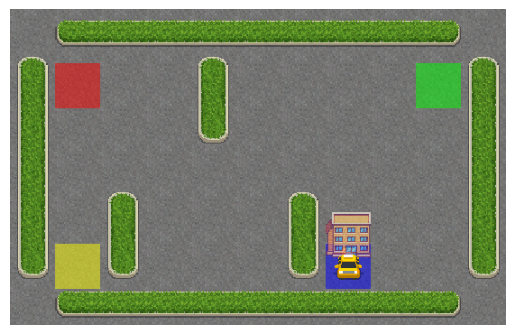

Episode Finished after 16 steps!
Final Reward for this episode: 5
Passenger delivered successfully!


In [30]:
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

#trying to visualize with trained parameters

print("\n--- Visualizing One Episode ---")
state = env.reset()
done = False
max_steps_visualization = 50 # Set a max steps to prevent infinite loop if something is wrong
total_episode_reward_viz = 0


# env.render(mode='human') would open a window, if running in local system

for step_viz in range(max_steps_visualization):
    clear_output(wait=True) # to cllear the previous frame

    try:
        rendered_frame = env.render(mode='rgb_array')
        if rendered_frame is not None:
            plt.imshow(rendered_frame)
            plt.axis('off') # Turn off axis numbers and ticks
            plt.show()
        else:
            #fallback if it doesnot render This just prints text representation
            print(f"Step: {step_viz + 1}")
            env.render(mode='ansi') # Renders text-based to console output

    except Exception as e:
        print(f"Rendering error: {e}. Falling back to ANSI render.")
        env.render(mode='ansi')


    print(f"Current State: {state}, Total Reward: {total_episode_reward_viz}")

    # whichever action has max Q value we choose it
    action = np.argmax(q_table[state, :])

    next_state, reward, done, info = env.step(action)

    state = next_state
    total_episode_reward_viz += reward

    time.sleep(0.5) # Pausing here for 1/2 second to see frame

    if done:
        clear_output(wait=True)
        try:
            rendered_frame = env.render(mode='rgb_array')
            if rendered_frame is not None:
                plt.imshow(rendered_frame)
                plt.axis('off')
                plt.show()
            else:
                env.render(mode='ansi')
        except Exception as e:
            print(f"Rendering error on final step: {e}. Falling back to ANSI render.")
            env.render(mode='ansi')

        print(f"Episode Finished after {step_viz + 1} steps!")
        print(f"Final Reward for this episode: {total_episode_reward_viz}")
        if reward == 20:
            print("Passenger delivered successfully!")
        else:
            print("Episode ended for other reasons (e.g., max steps in a real scenario, or unexpected outcome).")
        break

if not done:
    print("Visualization stopped due to max_steps_visualization limit.")

# env.close() # Important if you used mode='human' or if render creates resources.
# For 'rgb_array' and 'ansi' it's often not strictly necessary but good practice.